In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import pandas as pd
import scanpy as sc
import cellink as cl

/data/nasif12/home_if12/l_pock/.conda/envs/tap_scgenetics_v1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from cellink.tl._burden_testing import *

In [4]:
cell_type_col = "cell_label"

In [5]:
base_data_dir = Path("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/")
input_dir = base_data_dir / "input_data"
output_dir = base_data_dir / "output"
## defining the path to the data
scdata_path = input_dir / "chr22_OneK1K_cohort_gene_expression_matrix_14_celltypes.h5ad.gz"
gdata_path = input_dir / "plink/"
dump_path = base_data_dir / "output/example_output"
vep_anno_file = input_dir /  "all_variants_annotated_fixed_ref_reversed_id.txt"
DNA_LM_file = input_dir/ "annotations/onek1k_inf_scores_upstream_model.tsv"
## defining target chromosome
target_chromosome = "22"

In [8]:
chr22_all_results_CD8_ET=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr4_all_results.pkl")

In [9]:
chr22_all_results_CD8_ET

burden_gene      target_gene              burden_type    pvalue  \
0   ENSG00000250312  ENSG00000250312               CADD_PHRED  0.751114   
1   ENSG00000250312  ENSG00000250312                DNA_LM_up  0.023905   
2   ENSG00000250312  ENSG00000250312              DNA_LM_down  0.017960   
3   ENSG00000250312  ENSG00000250312            MAF_beta_1.25  0.468003   
4   ENSG00000250312  ENSG00000250312             DNA_LM_mixed  0.020870   
..              ...              ...                      ...       ...   
2   ENSG00000109536  ENSG00000109536              DNA_LM_down  0.111893   
3   ENSG00000109536  ENSG00000109536            MAF_beta_1.25  0.231051   
4   ENSG00000109536  ENSG00000109536             DNA_LM_mixed  0.080075   
5   ENSG00000109536  ENSG00000109536        GENE_TSS_DISTANCE  0.946327   
6   ENSG00000109536  ENSG00000109536  GENE_TSS_DISTANCE_SAIGE  0.104837   

        beta cell_type chromosome  
0  -0.001062    CD8 ET          4  
1  -0.007648    CD8 ET          4  
2  -0.008010    CD8 ET          4  
3  -0.002437    CD8 ET          4  
4  -0.007818    CD8 ET          4  
..       ...       ...        ...  
2   0.138889  CD4 SOX4          4  
3   0.105369  CD4 SOX4          4  
4   0.153090  CD4 SOX4          4  
5  -0.005932  CD4 SOX4          4  
6   0.142631  CD4 SOX4          4  

[39249 rows x 7 columns]

In [6]:
chr22_all_burdens_CD8_ET = pd.read_parquet("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/burdens/chr4_all_burdens.parquet")

In [7]:
chr22_all_burdens_CD8_ET

CADD_PHRED  DNA_LM_up  DNA_LM_down  MAF_beta_1.25  DNA_LM_mixed  \
id                                                                           
1_1           121.821   0.964373     1.065523     738.936419      1.065523   
2_2           208.295   0.997355     1.049443    1131.098784      1.049443   
3_3           122.122   0.849659     0.833419     724.727966      0.833419   
4_4           111.404   0.974905     1.125594     899.064858      1.125594   
6_6           153.365   0.839924     0.865445     969.341295      0.865445   
...               ...        ...          ...            ...           ...   
1077_1078    1050.869   3.010279     5.565690    6287.922197      4.038007   
1078_1079     952.619   2.775992     5.023766    5708.900399      3.672387   
1079_1080    1070.544   3.178828     5.579245    6808.963552      4.049833   
1080_1081    1090.340   2.755296     4.996579    6383.318073      3.696544   
1081_1082    1252.409   2.733158     4.991647    7312.010315      3.572935   

           GENE_TSS_DISTANCE  GENE_TSS_DISTANCE_SAIGE           Geneid  
id                                                                      
1_1               32400223.0                 0.601820  ENSG00000250312  
2_2               46941919.0                 1.156413  ENSG00000250312  
3_3               34441946.0                 1.333470  ENSG00000250312  
4_4               36401536.0                 0.829525  ENSG00000250312  
6_6               40892494.0                 1.164862  ENSG00000250312  
...                      ...                      ...              ...  
1077_1078        195203328.0                46.963150  ENSG00000258834  
1078_1079        172207260.0                41.017014  ENSG00000258834  
1079_1080        220704096.0                42.699628  ENSG00000258834  
1080_1081        179052309.0                55.400070  ENSG00000258834  
1081_1082        232697014.0                46.786828  ENSG00000258834  

[1258623 rows x 8 columns]

### ADD DNA_LM to annotations_0

In [41]:
def add_snp_id(DNA_LM):
    DNA_LM['snp_id'] = DNA_LM['Chromosome'] + "_" + DNA_LM['pos'].astype(str) + "_" + DNA_LM['ref'] + "_" + DNA_LM['alt']
    DNA_LM['snp_id'] = DNA_LM['snp_id'].str.replace('chr', '')
    
    # Set 'snap_id' as the index
    DNA_LM.set_index('snp_id', inplace=True)
    return DNA_LM

# Function to reverse ref/alt in DNA_LM where the reverse matches in data_gdata_varm
def reverse_and_update_snp_ids(gdata_df, dna_df):
    updated_index = []
    
    for snp_id in dna_df.index:
        if snp_id in gdata_df.index:
            updated_index.append(snp_id)
        else:
            chrom, pos, ref, alt = snp_id.split("_")
            reversed_snp_id = f"{chrom}_{pos}_{alt}_{ref}"  # Reverse ref and alt
            
            # Check if reversed_snp_id exists in data_df
            if reversed_snp_id in gdata_df.index:
                #print(f"Reversing {snp_id} to {reversed_snp_id}")
                updated_index.append(reversed_snp_id)
            else:
                print(f"Error, unknown snp_id {snp_id}")
                updated_index.append(snp_id)

            
    
    # Update DNA_LM's index
    dna_df.index = updated_index
    print("\nUpdated DNA_LM index:")
    print(dna_df.index)
    return dna_df

# Run the function
DNA_LM = pd.read_csv(DNA_LM_file,
            sep = '\t')
DNA_LM = add_snp_id(DNA_LM)
DNA_LM_chr22 = reverse_and_update_snp_ids(data.gdata.varm["annotations_0"], DNA_LM[DNA_LM["Chromosome"]=="chr22"])
data.gdata.varm["annotations_0"]["DNA_LM_influence_score"] = DNA_LM_chr22["influence_score"]
data.gdata.varm["annotations_0"]


Updated DNA_LM index:
Index(['22_16849573_G_A', '22_16849971_T_A', '22_16850437_A_G',
       '22_16851225_T_C', '22_16851356_T_C', '22_16851640_T_C',
       '22_16851673_G_A', '22_16851899_G_C', '22_16852312_A_G',
       '22_16852652_A_G',
       ...
       '22_51197602_A_T', '22_51198569_C_G', '22_51198868_C_T',
       '22_51198906_A_G', '22_51198998_A_C', '22_51202748_G_A',
       '22_51208568_T_G', '22_51211031_G_A', '22_51213613_T_C',
       '22_51216564_C_T'],
      dtype='object', length=96257)


gnomADe_EAS_AF Feature_type  Consequence_intergenic_variant  \
snp_id                                                                         
22_16849573_G_A             NaN            -                               1   
22_16849971_T_A             NaN            -                               1   
22_16850437_A_G             NaN            -                               1   
22_16851225_T_C             NaN            -                               1   
22_16851356_T_C             NaN            -                               1   
...                         ...          ...                             ...   
22_51202748_G_A             NaN   Transcript                               0   
22_51208568_T_G             NaN   Transcript                               0   
22_51211031_G_A             NaN   Transcript                               0   
22_51213613_T_C             NaN   Transcript                               0   
22_51216564_C_T             NaN   Transcript                               0   

                PHENO  Consequence_start_lost  gnomADe_AMR_AF  \
snp_id                                                          
22_16849573_G_A     -                       0             NaN   
22_16849971_T_A     -                       0             NaN   
22_16850437_A_G     -                       0             NaN   
22_16851225_T_C     -                       0             NaN   
22_16851356_T_C     -                       0             NaN   
...               ...                     ...             ...   
22_51202748_G_A     -                       0             NaN   
22_51208568_T_G     -                       0             NaN   
22_51211031_G_A     -                       0             NaN   
22_51213613_T_C     -                       0             NaN   
22_51216564_C_T     -                       0             NaN   

                Existing_variation CLIN_SIG  CADD_RAW  gnomADe_NFE_AF  ...  \
snp_id                                                                 ...   
22_16849573_G_A        rs112435201        -  0.433139             NaN  ...   
22_16849971_T_A          rs7287956        -  0.442607             NaN  ...   
22_16850437_A_G          rs5748209        -  0.369731             NaN  ...   
22_16851225_T_C          rs5746874        -  0.393139             NaN  ...   
22_16851356_T_C          rs5748581        -  0.377289             NaN  ...   
...                            ...      ...       ...             ...  ...   
22_51202748_G_A          rs9616963        -  0.550962             NaN  ...   
22_51208568_T_G        rs148425445        -  0.102244             NaN  ...   
22_51211031_G_A          rs9616968        -  0.153297             NaN  ...   
22_51213613_T_C         rs34726907        - -0.394121             NaN  ...   
22_51216564_C_T          rs9616970        - -0.113869             NaN  ...   

                 Consequence_splice_donor_5th_base_variant  \
snp_id                                                       
22_16849573_G_A                                          0   
22_16849971_T_A                                          0   
22_16850437_A_G                                          0   
22_16851225_T_C                                          0   
22_16851356_T_C                                          0   
...                                                    ...   
22_51202748_G_A                                          0   
22_51208568_T_G                                          0   
22_51211031_G_A                                          0   
22_51213613_T_C                                          0   
22_51216564_C_T                                          0   

                 Consequence_splice_donor_region_variant  \
snp_id                                                     
22_16849573_G_A                                        0   
22_16849971_T_A                                        0   
22_16850437_A_G                                        0   
22_16851

## Add MAF beta 1.25

In [42]:
# get MAF
data.gdata.var["maf"]

snp_id
22_16849573_G_A    0.383462
22_16849971_T_A    0.383462
22_16850437_A_G    0.383462
22_16851225_T_C    0.383462
22_16851356_T_C    0.383462
                     ...   
22_51202748_G_A    0.067698
22_51208568_T_G    0.067215
22_51211031_G_A    0.064797
22_51213613_T_C    0.132495
22_51216564_C_T    0.132495
Name: maf, Length: 96257, dtype: float64

In [43]:
from scipy.stats import beta
print(data.gdata.var["maf"])
weighted_snp_maf = beta.pdf(data.gdata.var["maf"], 1, 25)
print(weighted_snp_maf)

snp_id
22_16849573_G_A    0.383462
22_16849971_T_A    0.383462
22_16850437_A_G    0.383462
22_16851225_T_C    0.383462
22_16851356_T_C    0.383462
                     ...   
22_51202748_G_A    0.067698
22_51208568_T_G    0.067215
22_51211031_G_A    0.064797
22_51213613_T_C    0.132495
22_51216564_C_T    0.132495
Name: maf, Length: 96257, dtype: float64
[2.27494875e-04 2.27494875e-04 2.27494875e-04 ... 5.00820914e+00
 8.25022346e-01 8.25022346e-01]


In [44]:
data.gdata.varm["annotations_0"]["MAF_beta_1.25"] = weighted_snp_maf
data.gdata.varm["annotations_0"]

gnomADe_EAS_AF Feature_type  Consequence_intergenic_variant  \
snp_id                                                                         
22_16849573_G_A             NaN            -                               1   
22_16849971_T_A             NaN            -                               1   
22_16850437_A_G             NaN            -                               1   
22_16851225_T_C             NaN            -                               1   
22_16851356_T_C             NaN            -                               1   
...                         ...          ...                             ...   
22_51202748_G_A             NaN   Transcript                               0   
22_51208568_T_G             NaN   Transcript                               0   
22_51211031_G_A             NaN   Transcript                               0   
22_51213613_T_C             NaN   Transcript                               0   
22_51216564_C_T             NaN   Transcript                               0   

                PHENO  Consequence_start_lost  gnomADe_AMR_AF  \
snp_id                                                          
22_16849573_G_A     -                       0             NaN   
22_16849971_T_A     -                       0             NaN   
22_16850437_A_G     -                       0             NaN   
22_16851225_T_C     -                       0             NaN   
22_16851356_T_C     -                       0             NaN   
...               ...                     ...             ...   
22_51202748_G_A     -                       0             NaN   
22_51208568_T_G     -                       0             NaN   
22_51211031_G_A     -                       0             NaN   
22_51213613_T_C     -                       0             NaN   
22_51216564_C_T     -                       0             NaN   

                Existing_variation CLIN_SIG  CADD_RAW  gnomADe_NFE_AF  ...  \
snp_id                                                                 ...   
22_16849573_G_A        rs112435201        -  0.433139             NaN  ...   
22_16849971_T_A          rs7287956        -  0.442607             NaN  ...   
22_16850437_A_G          rs5748209        -  0.369731             NaN  ...   
22_16851225_T_C          rs5746874        -  0.393139             NaN  ...   
22_16851356_T_C          rs5748581        -  0.377289             NaN  ...   
...                            ...      ...       ...             ...  ...   
22_51202748_G_A          rs9616963        -  0.550962             NaN  ...   
22_51208568_T_G        rs148425445        -  0.102244             NaN  ...   
22_51211031_G_A          rs9616968        -  0.153297             NaN  ...   
22_51213613_T_C         rs34726907        - -0.394121             NaN  ...   
22_51216564_C_T          rs9616970        - -0.113869             NaN  ...   

                 Consequence_splice_donor_5th_base_variant  \
snp_id                                                       
22_16849573_G_A                                          0   
22_16849971_T_A                                          0   
22_16850437_A_G                                          0   
22_16851225_T_C                                          0   
22_16851356_T_C                                          0   
...                                                    ...   
22_51202748_G_A                                          0   
22_51208568_T_G                                          0   
22_51211031_G_A                                          0   
22_51213613_T_C                                          0   
22_51216564_C_T                                          0   

                 Consequence_splice_donor_region_variant  \
snp_id                                                     
22_16849573_G_A                                        0   
22_16849971_T_A                                        0   
22_16850437_A_G                                        0   
22_16851

## Compute Burdens and save results

In [14]:
output_dir

PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output')

In [94]:
all_burdens = compute_burdens(data, max_af=0.05, weight_cols=["DISTANCE", "CADD_PHRED", "DNA_LM_influence_score", "MAF_beta_1.25"])



00%|██████████| 673/673 [24:18<00:00,  2.17s/it]

In [45]:
# save burdens
burdens_path = output_dir/"all_burdens_chr22_with_DNA_LM_and_MAF.parquet"

all_burdens.to_parquet(burdens_path)

# save data object
data_path = output_dir/"data.pkl"
with open(data_path, "wb") as file:
    pickle.dump(data, file)

## read data object and burdens

In [46]:
burdens_path = output_dir/"all_burdens_chr22_with_DNA_LM_and_MAF.parquet"

all_burdens = pd.read_parquet(burdens_path)

In [47]:
import pickle
# read data
data_path = output_dir/"data.pkl"
with open(data_path, "rb") as file:
    data = pickle.load(file)

### run association testing

In [48]:
cell_types = data.adata.obs["cell_label"].unique()
cell_types

['CD8 ET', 'CD8 NC', 'CD4 NC', 'Mono C', 'NK', ..., 'DC', 'NK R', 'Platelets', 'CD4 SOX4', 'Erythrocytes']
Length: 16
Categories (16, object): ['B IN', 'B Mem', 'CD4 ET', 'CD4 NC', ..., 'NK', 'NK R', 'Plasma', 'Platelets']

In [49]:
all_res = []
#cell_types = ["CD4 NC", "B IN", "B Mem"]
for target_cell_type in cell_types:
    print(target_cell_type)
    this_res = burden_test(
            donor_data = data,
            gene_burdens = all_burdens,
            target_cell_type = target_cell_type,
            target_chromosome = target_chromosome,
            dump_dir = dump_path,
            # target_genes = target_genes,
            transforms_seq = None #TODO comment this back in to quantile transform phenotype. Commented out to make testing faster
            )
    all_res.append(this_res[0])
all_res = pd.concat(all_res)



CD8 ET


TypeError: burden_test() missing 1 required positional argument: 'eigenvector_df'

In [50]:
all_res["pvalue_corrected"] = all_res["pvalue"] * len(all_res)
all_res["significant"] = all_res["pvalue_corrected"] < 0.05
# save results
res_path = output_dir/"all_results_DNA_LM_and_MAF.pkl"
with open(res_path, "wb") as file:
    pickle.dump(all_res, file)

TypeError: list indices must be integers or slices, not str

In [52]:
# read results
res_path = output_dir/"all_results_DNA_LM_and_MAF.pkl"
with open(res_path, "rb") as file:
    all_res = pickle.load(file)

## Evaluate results: NOT FILTERED

In [53]:
all_res.query("significant & burden_type== 'DISTANCE'")

burden_gene      target_gene burden_type        pvalue      beta  \
0  ENSG00000100376  ENSG00000100376    DISTANCE  1.502460e-08 -0.023816   
0  ENSG00000075234  ENSG00000075234    DISTANCE  4.470123e-07 -0.020673   
0  ENSG00000100376  ENSG00000100376    DISTANCE  5.136712e-09 -0.041879   
0  ENSG00000212939  ENSG00000212939    DISTANCE  5.324983e-09 -0.005073   
0  ENSG00000212939  ENSG00000212939    DISTANCE  8.445424e-09 -0.002317   
0  ENSG00000167074  ENSG00000167074    DISTANCE  7.373925e-07 -0.005990   
0  ENSG00000128408  ENSG00000128408    DISTANCE  1.601872e-06 -0.002153   
0  ENSG00000075234  ENSG00000075234    DISTANCE  3.040578e-36 -0.118458   
0  ENSG00000212939  ENSG00000212939    DISTANCE  3.559688e-09 -0.005929   
0  ENSG00000100376  ENSG00000100376    DISTANCE  1.654377e-08 -0.093123   
0  ENSG00000100376  ENSG00000100376    DISTANCE  8.291006e-08 -0.038754   
0  ENSG00000188130  ENSG00000188130    DISTANCE  8.652732e-07 -0.001896   
0  ENSG00000100376  ENSG00000100376    DISTANCE  9.725303e-09 -0.030472   
0  ENSG00000100376  ENSG00000100376    DISTANCE  5.143481e-07 -0.118415   
0  ENSG00000099968  ENSG00000099968    DISTANCE  1.579464e-06 -0.156428   

      cell_type chrom  pvalue_corrected  significant  
0        CD8 ET    22      3.797619e-04         True  
0        CD8 ET    22      1.129868e-02         True  
0        CD8 NC    22      1.298355e-04         True  
0        CD8 NC    22      1.345943e-04         True  
0        CD4 NC    22      2.134665e-04         True  
0        Mono C    22      1.863833e-02         True  
0        Mono C    22      4.048892e-02         True  
0            NK    22      7.685364e-32         True  
0            NK    22      8.997467e-05         True  
0       Mono NC    22      4.181604e-04         True  
0     CD8 S100B    22      2.095635e-03         True  
0     CD8 S100B    22      2.187065e-02         True  
0         B Mem    22      2.458168e-04         True  
0            DC    22      1.300066e-02         True  
0  Erythrocytes    22      3.992254e-02         True

In [29]:
e_genes_per_cell_type = all_res\
    .groupby(["cell_type", "burden_type"])["significant"].sum()\
    .to_frame(name = "count").reset_index()
e_genes_per_cell_type

cell_type             burden_type  count
0        B IN              CADD_PHRED      1
1        B IN                DISTANCE      0
2        B IN  DNA_LM_influence_score      2
3        B IN           MAF_beta_1.25      2
4       B Mem              CADD_PHRED      2
..        ...                     ...    ...
59     Plasma           MAF_beta_1.25      1
60  Platelets              CADD_PHRED      1
61  Platelets                DISTANCE      0
62  Platelets  DNA_LM_influence_score      1
63  Platelets           MAF_beta_1.25      1

[64 rows x 3 columns]

In [30]:
zero_types = list(e_genes_per_cell_type.groupby("cell_type").sum().query("count ==0").index)

[2025-01-02 14:36:31,526] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


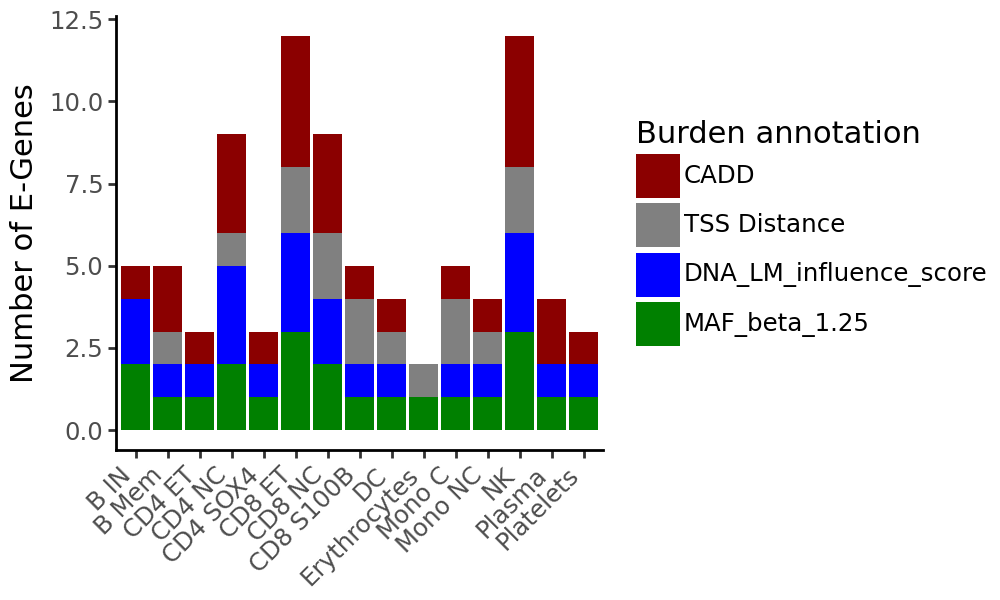

In [31]:
from plotnine import *
plot = (
    ggplot(e_genes_per_cell_type.query("cell_type not in @zero_types"), 
           aes(x='cell_type', y='count'))  # Specify the x and y variables
    + geom_bar(aes(fill = "burden_type"), stat = "identity")  # Add the boxplot layer
    + theme_classic()  # Optional: use a clean theme
    + theme(axis_text_x = element_text(angle = 45, hjust = 1, vjust = 1), figure_size = (5,3)) 
            #legend_position="none")
    + labs(y = "Number of E-Genes", x = "", fill = "Burden annotation")
    + scale_fill_manual(values = ['darkred', "grey", "blue", "green"], labels = ["CADD",  "TSS Distance", "DNA_LM_influence_score", "MAF_beta_1.25"])
)
plot

[2025-01-02 14:42:58,390] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


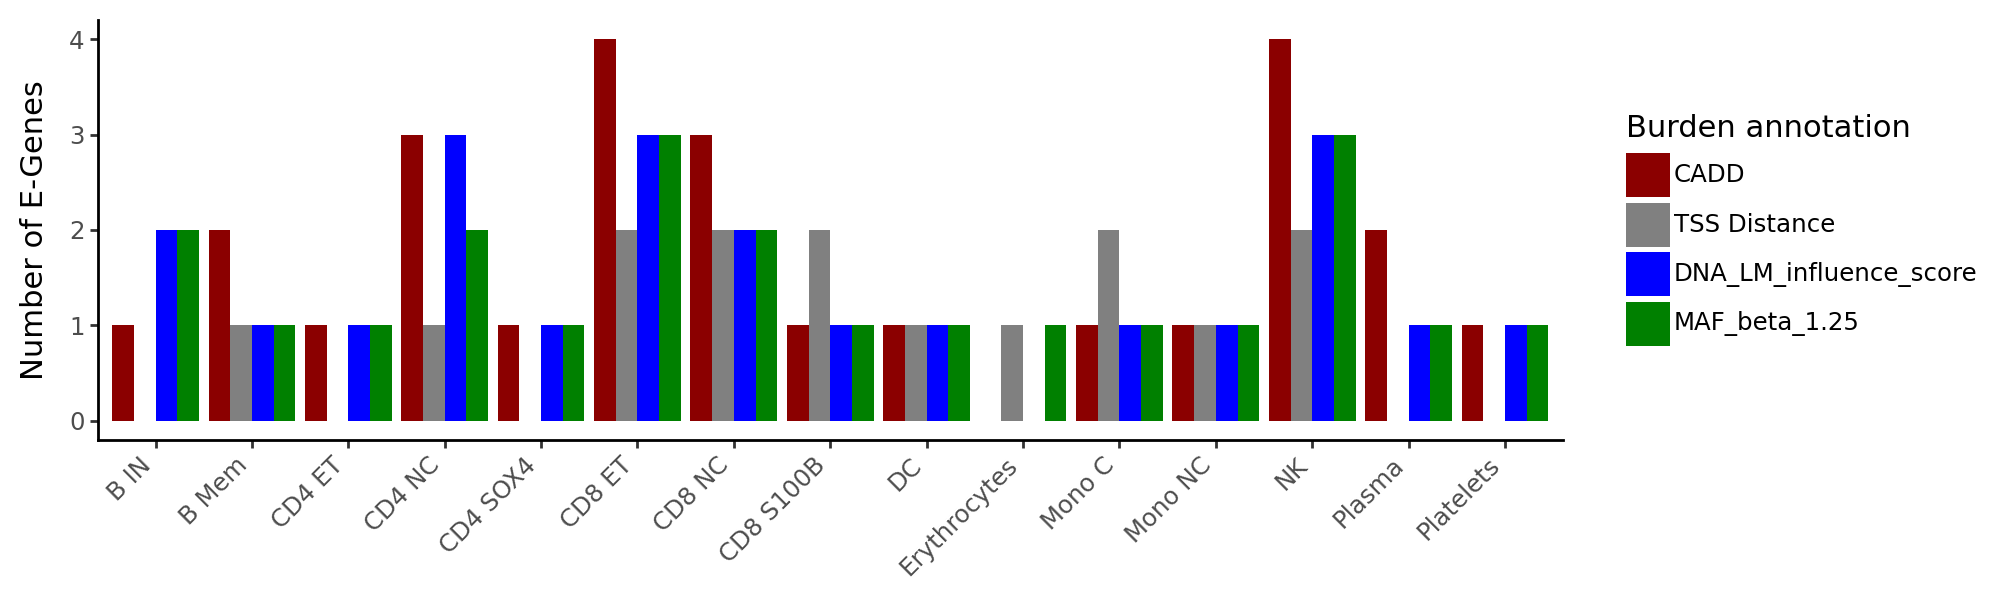

In [33]:
from plotnine import *
plot = (
    ggplot(e_genes_per_cell_type.query("cell_type not in @zero_types"), 
           aes(x='cell_type', y='count'))  # Specify the x and y variables
    + geom_bar(aes(fill = "burden_type"), stat = "identity", position = "dodge")  # Add the bar plot layer with dodged position
    + theme_classic()  # Optional: use a clean theme
    + theme(axis_text_x = element_text(angle = 45, hjust = 1, vjust = 1), figure_size = (10,3))  # Adjust text orientation and plot size
    + labs(y = "Number of E-Genes", x = "", fill = "Burden annotation")  # Labels for the plot
    + scale_fill_manual(values = ['darkred', "grey", "blue", "green"], 
                        labels = ["CADD",  "TSS Distance", "DNA_LM_influence_score", "MAF_beta_1.25"])  # Manually set the colors and labels for the fill legend
)
plot


[2024-12-19 12:15:55,109] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


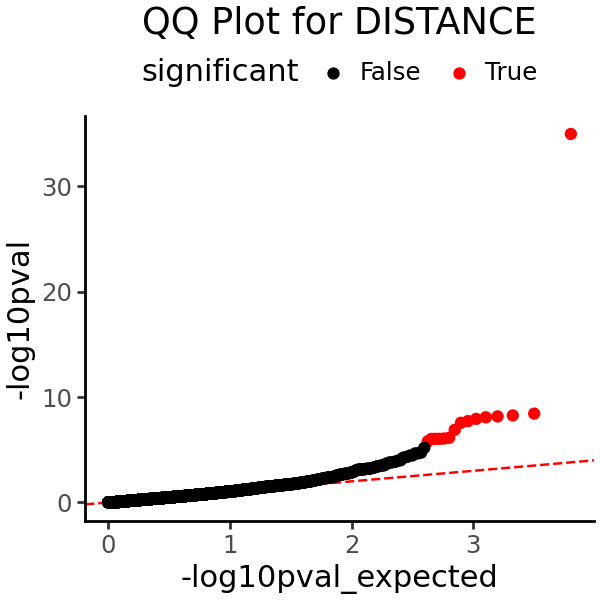

[2024-12-19 12:15:55,487] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


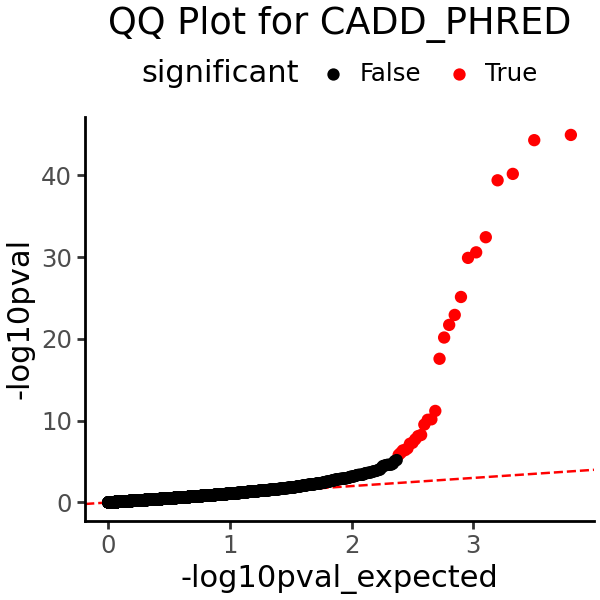

[2024-12-19 12:15:55,887] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


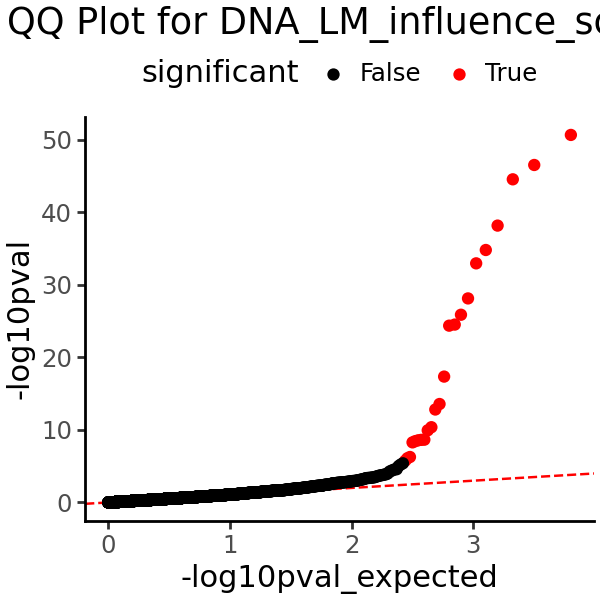

[2024-12-19 12:15:56,269] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


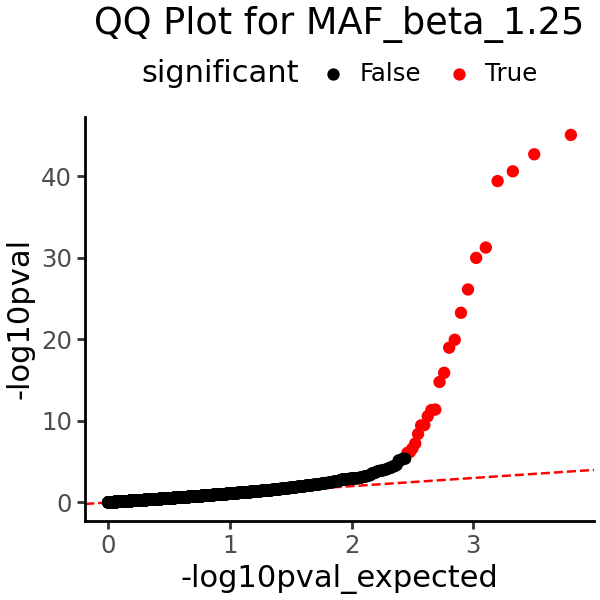

In [27]:
for burden_type in all_res['burden_type'].unique():
    # Filtere den DataFrame für den aktuellen 'burden_type'
    df = all_res[all_res['burden_type'] == burden_type].copy()
    df = df.sort_values('pvalue')
    df['-log10pval_expected'] = -np.log10(np.arange(1, len(df) + 1) / len(df))

    if '-log10pval' not in df.columns:
        df['-log10pval'] = -np.log10(df['pvalue'])

    aes_kwargs = dict(x='-log10pval_expected', y='-log10pval', color='significant')
    plot = (
        ggplot(df, aes(**aes_kwargs))
        + labs(title=f'QQ Plot for {burden_type}')
        + scale_color_manual(values=["black", "red"])
        + theme_classic()
        + geom_abline(intercept=0, slope=1, color="red", linetype="dashed")
        + geom_point()
        + theme(legend_position='top', figure_size=(3, 3))
    )
    plot.show()

In [33]:
plot = (
    ggplot(e_genes_per_cell_type.query("significant == True"), 
           aes(x='pvalue', y='beta', color='burden_type'))
    + geom_point()
    + scale_color_manual(values=['darkred', "grey", "blue", "green"], labels=["CADD", "TSS Distance", "DNA_LM_influence_score", "MAF_beta_1.25"])
    + theme_classic()
    + theme(axis_text_x=element_text(angle=45, hjust=1, vjust=1), figure_size=(5,3))
    + labs(x="p-value", y="Beta Value", color="Burden annotation")
)
plot


UndefinedVariableError: name 'significant' is not defined

In [109]:
sig_genes_cd4 = all_res.query("cell_type == 'CD4 NC' & significant")["burden_gene"].unique()
sig_genes_cd4
all_res.query("significant & burden_gene not in @sig_genes_cd4")

burden_gene      target_gene             burden_type        pvalue  \
0  ENSG00000100376  ENSG00000100376                DISTANCE  1.915882e-08   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  6.576610e-41   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  2.962627e-47   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  1.970468e-43   
0  ENSG00000075234  ENSG00000075234                DISTANCE  9.409083e-07   
1  ENSG00000075234  ENSG00000075234              CADD_PHRED  4.341488e-07   
2  ENSG00000075234  ENSG00000075234  DNA_LM_influence_score  8.002968e-07   
3  ENSG00000075234  ENSG00000075234           MAF_beta_1.25  6.526352e-07   
0  ENSG00000100376  ENSG00000100376                DISTANCE  6.865553e-09   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  1.123937e-45   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  2.123544e-51   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  8.315662e-46   
0  ENSG00000167074  ENSG00000167074                DISTANCE  8.991440e-07   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  6.344401e-12   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  2.682561e-14   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  4.022593e-12   
0  ENSG00000128408  ENSG00000128408                DISTANCE  1.666894e-06   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  1.946241e-22   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  1.320343e-26   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  5.472479e-24   
0  ENSG00000075234  ENSG00000075234                DISTANCE  1.029877e-35   
1  ENSG00000075234  ENSG00000075234              CADD_PHRED  3.966427e-40   
2  ENSG00000075234  ENSG00000075234  DNA_LM_influence_score  6.726650e-39   
3  ENSG00000075234  ENSG00000075234           MAF_beta_1.25  3.811322e-40   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  3.670458e-33   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  1.564509e-35   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  5.442192e-32   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  4.959931e-45   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  2.822280e-45   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  2.428840e-41   
0  ENSG00000100376  ENSG00000100376                DISTANCE  2.805409e-08   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  7.134458e-21   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  3.121486e-25   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  1.080970e-19   
0  ENSG00000100376  ENSG00000100376                DISTANCE  1.285431e-07   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  1.228652e-30   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  7.298681e-29   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  7.443593e-27   
0  ENSG00000188130  ENSG00000188130                DISTANCE  9.151080e-07   
0  ENSG00000100376  ENSG00000100376                DISTANCE  1.176164e-08   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  2.604993e-31   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  1.090351e-33   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  1.013244e-30   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  6.545877e-18   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  1.145956e-17   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  2.915004e-16   
0  ENSG00000100376  ENSG00000100376                DISTANCE  7.249429e-07   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  1.145922e-23   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  4.199012e-25   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  1.094927e-20   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  1.804196e-06   
1  

In [51]:
gene_oi = "ENSG00000187905"

In [52]:
all_res.query("burden_gene == @gene_oi & burden_type == 'DISTANCE'")

burden_gene      target_gene burden_type    pvalue      beta  \
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.405888  0.000134   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.334092  0.000146   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.062503  0.000157   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.354069 -0.000315   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.680585  0.000069   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.340722  0.000207   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.125368  0.000282   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.582547 -0.000218   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.438788  0.000241   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.231570  0.000304   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.962260 -0.000039   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.859557  0.000278   

   cell_type chrom  pvalue_corrected  significant  
0     CD8 ET    22       5129.610406        False  
0     CD8 NC    22       4222.253486        False  
0     CD4 NC    22        789.917530        False  
0     Mono C    22       4474.720849        False  
0         NK    22       8601.237355        False  
0       B IN    22       4306.046887        False  
0     CD4 ET    22       1584.406356        False  
0    Mono NC    22       7362.229396        False  
0  CD8 S100B    22       5545.408614        False  
0      B Mem    22       2926.579449        False  
0         DC    22      12161.042181        False  
0       NK R    22      10863.084997        False

In [60]:
all_res.query("significant").groupby("burden_gene").size().to_frame(name = "Number of Sig. cell types")#.loc[gene_oi]

Number of Sig. cell types
burden_gene                               
ENSG00000075234                          4
ENSG00000099968                          1
ENSG00000100219                          1
ENSG00000100376                         19
ENSG00000128408                          1
ENSG00000167074                          1
ENSG00000184983                          6
ENSG00000188130                          1
ENSG00000212939                          7

In [61]:
this_ddata_mono = compute_pseudobulks(ddata, "Plasma")
this_ddata_cd = compute_pseudobulks(ddata, "CD4 NC")

NameError: name 'compute_pseudobulks' is not defined

In [47]:
y_cd = this_ddata_cd.gdata.obsm["pseudo_mean"][gene_oi] 
y_mono = this_ddata_mono.gdata.obsm["pseudo_mean"][gene_oi]
b = this_ddata_mono.gdata.uns['gene_burdens'].query("Gene == @gene_oi")["CADD_PHRED"]

In [51]:
merged = y_cd.to_frame(name = "CD4 NC").join(y_mono.to_frame(name = "Plasma")).join(b)
merged = merged.reset_index()\
    .melt(id_vars = ["CADD_PHRED", "id"], value_vars = ["CD4 NC","Plasma"], var_name = "Cell type", value_name = "Expression")
merged

CADD_PHRED         id Cell type  Expression
0          9.514        1_1    CD4 NC    0.000924
1          0.000        2_2    CD4 NC    0.000000
2          0.000        3_3    CD4 NC    0.002641
3          0.000        4_4    CD4 NC    0.001961
4          0.000        6_6    CD4 NC    0.000885
...          ...        ...       ...         ...
1957       0.000  1077_1078    Plasma    0.000000
1958       0.000  1078_1079    Plasma    0.000000
1959       0.000  1079_1080    Plasma    0.000000
1960       3.481  1080_1081    Plasma    0.000000
1961       0.000  1081_1082    Plasma    0.000000

[1962 rows x 4 columns]

/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 72 rows containing missing values.


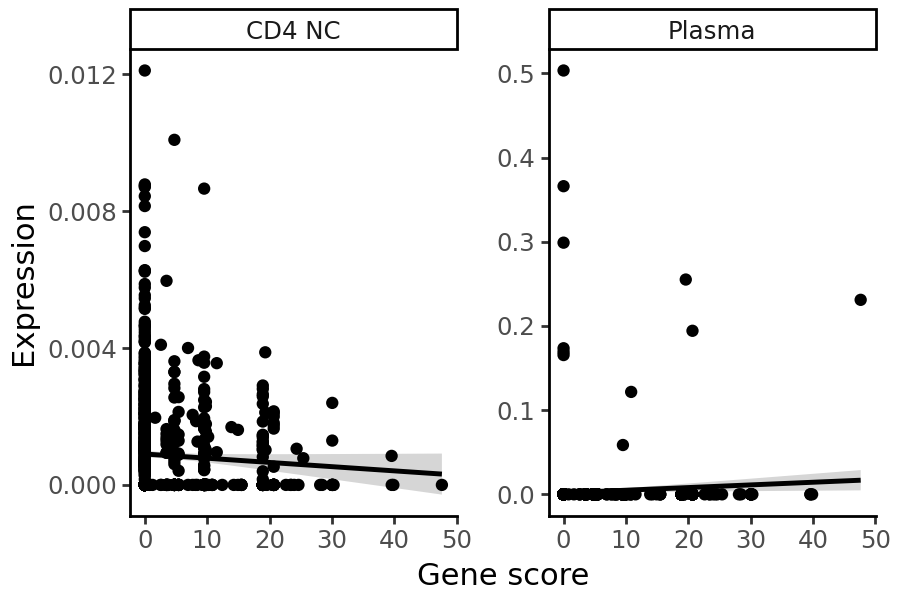

In [58]:
plot = (
    ggplot(merged, aes(x = "CADD_PHRED", y = "Expression"))
    + labs(x = "Gene score")
    + theme_classic()
    + geom_smooth()
    + geom_point()
    + facet_wrap("Cell type", scales = "free")
    + theme(legend_position="top", figure_size = (4.5,3))
)
plot

### Understanding burden computation

In [32]:
this_vars =data.gdata.varm["annotations_0"][data.gdata.varm["annotations_0"]["Gene"] == "ENSG00000184319"].index
this_vars


Index(['22_51197576_C_G', '22_51198868_C_T', '22_51198906_A_G',
       '22_51198998_A_C', '22_51202748_G_A', '22_51208568_T_G',
       '22_51211031_G_A', '22_51213613_T_C', '22_51216564_C_T'],
      dtype='object', name='snp_id')

In [24]:
data.gdata.varm["annotations_0"]["Gene"]

snp_id
22_16849573_G_A                  -
22_16849971_T_A                  -
22_16850437_A_G                  -
22_16851225_T_C                  -
22_16851356_T_C                  -
                        ...       
22_51202748_G_A    ENSG00000184319
22_51208568_T_G    ENSG00000184319
22_51211031_G_A    ENSG00000184319
22_51213613_T_C    ENSG00000184319
22_51216564_C_T    ENSG00000184319
Name: Gene, Length: 96257, dtype: object

In [28]:
data.gdata.varm["annotations_0"]["Location"]

snp_id
22_16849573_G_A    22:16849573
22_16849971_T_A    22:16849971
22_16850437_A_G    22:16850437
22_16851225_T_C    22:16851225
22_16851356_T_C    22:16851356
                      ...     
22_51202748_G_A    22:51202748
22_51208568_T_G    22:51208568
22_51211031_G_A    22:51211031
22_51213613_T_C    22:51213613
22_51216564_C_T    22:51216564
Name: Location, Length: 96257, dtype: object

In [46]:
## we need the location of the gene-> choose vars based on window
#todo: test +/- strand

In [38]:
import requests

def get_gene_location(ensembl_id):
    url = f"https://rest.ensembl.org/lookup/id/{ensembl_id}?content-type=application/json"
    response = requests.get(url)
    if response.ok:
        data = response.json()
        return f"{data.get('seq_region_name')}:{data.get('start')}-{data.get('end')}"
    else:
        return f"Error: {response.status_code}, {response.text}"


In [39]:
#eg:
gene_id = "ENSG00000184319"
location = get_gene_location(gene_id)
print(location)

22:50798655-50799123


In [44]:
import pandas as pd

def find_snps_near_gene(gdata, gene_location, bp_range=10000):
    """
    Finds SNPs within a specified range of a gene's location.

    Parameters:
        gdata (pd.DataFrame): DataFrame with a 'Location' column in the format "chromosome:position".
        gene_location (str): Gene location in the format "chromosome:start-end".
        bp_range (int): Range in base pairs to search upstream and downstream.

    Returns:
        pd.Index: Index of SNPs within the specified range.
    """
    # Parse the gene location
    gene_chrom, gene_range = gene_location.split(":")
    gene_start, gene_end = map(int, gene_range.split("-"))

    # Extract chromosome and position from the SNPs
    gdata[['Chromosome', 'Position']] = gdata['Location'].str.split(':', expand=True)
    gdata['Position'] = gdata['Position'].astype(int)

    # Filter for SNPs within the range
    snps_in_range = gdata[
        (gdata['Chromosome'] == gene_chrom) &
        (gdata['Position'] >= gene_start - bp_range) &
        (gdata['Position'] <= gene_end + bp_range)
    ]

    return snps_in_range.index


In [45]:

# Find SNPs within 10,000 bp of the gene
result = find_snps_near_gene(data.gdata.varm["annotations_0"], location, bp_range=10000)
print(result)


Index(['22_50788696_A_G', '22_50788848_T_C', '22_50789302_T_C',
       '22_50789797_A_G', '22_50789956_A_G', '22_50790558_T_C',
       '22_50790915_G_T', '22_50791201_A_G', '22_50791260_T_C',
       '22_50791513_T_C', '22_50792104_A_C', '22_50792374_G_A',
       '22_50792826_G_A', '22_50793661_C_T', '22_50794255_A_T',
       '22_50794282_A_C', '22_50794538_T_C', '22_50794804_G_C',
       '22_50795071_T_C', '22_50795146_T_A', '22_50795310_C_G',
       '22_50795342_A_G', '22_50795620_G_A', '22_50795806_G_C',
       '22_50795934_C_T', '22_50796278_T_C', '22_50796296_A_G',
       '22_50796448_A_G', '22_50796460_A_G', '22_50797256_A_C',
       '22_50797973_G_A', '22_50798134_C_T', '22_50798212_A_G',
       '22_50798585_A_G', '22_50799169_G_A', '22_50799684_C_A',
       '22_50799845_G_A', '22_50800769_G_C', '22_50800929_A_G',
       '22_50801156_G_C', '22_50801334_A_G', '22_50802074_T_C',
       '22_50802635_T_A', '22_50802642_C_T', '22_50802699_T_G',
       '22_50803110_A_G', '22_50803458_C

In [34]:
get_gene_location(gene_id)

('RPL23AP82', '22', 50798655, 50799123, 1)

In [50]:
test=compute_burdens(data, max_af=0.05, weight_cols=["DISTANCE", "CADD_PHRED", "DNA_LM_influence_score", "MAF_beta_1.25"], window_size=100)


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:59: ImplicitModificationWarning: Trying to modify attribute `.varm` of view, initializing view as actual.
  gdata[['Chromosome', 'Position']] = gdata['Location'].str.split(':', expand=True)
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:60: ImplicitModificationWarning: Trying to modify attribute `.varm` of view, initializing view as actual.
  gdata['Position'] = gdata['Position'].astype(int)
  1%|          | 8/673 [00:25<34:40,  3.13s/it]

Failed to retrieve location for gene ENSG00000273203. Falling back to 'Gene' column.


  3%|▎         | 17/673 [00:52<33:22,  3.05s/it]

Failed to retrieve location for gene ENSG00000272675. Falling back to 'Gene' column.


 11%|█▏        | 76/673 [03:52<30:15,  3.04s/it]

Failed to retrieve location for gene ENSG00000188424. Falling back to 'Gene' column.


 11%|█▏        | 77/673 [03:55<29:37,  2.98s/it]

Failed to retrieve location for gene ENSG00000223579. Falling back to 'Gene' column.


 13%|█▎        | 86/673 [04:21<28:26,  2.91s/it]

Failed to retrieve location for gene ENSG00000234252. Falling back to 'Gene' column.


 18%|█▊        | 118/673 [05:56<27:15,  2.95s/it]

Failed to retrieve location for gene ENSG00000225070. Falling back to 'Gene' column.


 18%|█▊        | 120/673 [06:02<26:55,  2.92s/it]

Failed to retrieve location for gene ENSG00000198477. Falling back to 'Gene' column.


 21%|██        | 138/673 [06:57<27:51,  3.12s/it]

Failed to retrieve location for gene ENSG00000270041. Falling back to 'Gene' column.


 23%|██▎       | 157/673 [07:56<26:51,  3.12s/it]

Failed to retrieve location for gene ENSG00000272955. Falling back to 'Gene' column.


 29%|██▉       | 198/673 [10:03<23:51,  3.01s/it]

Failed to retrieve location for gene ENSG00000260065. Falling back to 'Gene' column.


 30%|███       | 205/673 [10:25<24:21,  3.12s/it]

Failed to retrieve location for gene ENSG00000223704. Falling back to 'Gene' column.


 31%|███       | 206/673 [10:28<24:03,  3.09s/it]

Failed to retrieve location for gene ENSG00000235271. Falling back to 'Gene' column.


 37%|███▋      | 247/673 [12:36<22:27,  3.16s/it]

Failed to retrieve location for gene ENSG00000239446. Falling back to 'Gene' column.


 39%|███▉      | 265/673 [13:32<20:58,  3.09s/it]

Failed to retrieve location for gene ENSG00000241528. Falling back to 'Gene' column.


 40%|███▉      | 269/673 [13:44<20:28,  3.04s/it]

Failed to retrieve location for gene ENSG00000268538. Falling back to 'Gene' column.


 45%|████▍     | 302/673 [15:26<19:34,  3.17s/it]

Failed to retrieve location for gene ENSG00000224623. Falling back to 'Gene' column.


 46%|████▋     | 312/673 [15:56<18:49,  3.13s/it]

Failed to retrieve location for gene ENSG00000239674. Falling back to 'Gene' column.


 47%|████▋     | 318/673 [16:14<18:07,  3.06s/it]

Failed to retrieve location for gene ENSG00000224050. Falling back to 'Gene' column.


 51%|█████     | 342/673 [17:27<16:33,  3.00s/it]

Failed to retrieve location for gene ENSG00000227895. Falling back to 'Gene' column.


 58%|█████▊    | 388/673 [19:48<14:39,  3.08s/it]

Failed to retrieve location for gene ENSG00000183473. Falling back to 'Gene' column.


 67%|██████▋   | 449/673 [22:56<11:38,  3.12s/it]

Failed to retrieve location for gene ENSG00000235209. Falling back to 'Gene' column.


 68%|██████▊   | 460/673 [23:29<10:59,  3.09s/it]

Failed to retrieve location for gene ENSG00000214854. Falling back to 'Gene' column.


 73%|███████▎  | 489/673 [24:59<09:23,  3.06s/it]

Failed to retrieve location for gene ENSG00000232754. Falling back to 'Gene' column.


 74%|███████▎  | 495/673 [25:17<09:13,  3.11s/it]

Failed to retrieve location for gene ENSG00000269104. Falling back to 'Gene' column.


 76%|███████▋  | 514/673 [26:16<08:16,  3.12s/it]

Failed to retrieve location for gene ENSG00000260655. Falling back to 'Gene' column.


 78%|███████▊  | 527/673 [26:55<07:22,  3.03s/it]

Failed to retrieve location for gene ENSG00000233903. Falling back to 'Gene' column.


 78%|███████▊  | 528/673 [26:59<07:25,  3.07s/it]

Failed to retrieve location for gene ENSG00000273366. Falling back to 'Gene' column.


 88%|████████▊ | 589/673 [30:07<04:14,  3.03s/it]

Failed to retrieve location for gene ENSG00000273289. Falling back to 'Gene' column.


 88%|████████▊ | 590/673 [30:10<04:07,  2.99s/it]

Failed to retrieve location for gene ENSG00000241990. Falling back to 'Gene' column.


 91%|█████████ | 610/673 [31:11<03:12,  3.06s/it]

Failed to retrieve location for gene ENSG00000230345. Falling back to 'Gene' column.


 92%|█████████▏| 616/673 [31:29<02:57,  3.11s/it]

Failed to retrieve location for gene ENSG00000219016. Falling back to 'Gene' column.


 96%|█████████▌| 644/673 [32:55<01:29,  3.08s/it]

Failed to retrieve location for gene ENSG00000268427. Falling back to 'Gene' column.


 97%|█████████▋| 653/673 [33:22<00:59,  3.00s/it]

Failed to retrieve location for gene ENSG00000130489. Falling back to 'Gene' column.


 98%|█████████▊| 659/673 [33:39<00:41,  2.96s/it]

Failed to retrieve location for gene ENSG00000226738. Falling back to 'Gene' column.


 99%|█████████▉| 666/673 [34:00<00:20,  2.97s/it]

Failed to retrieve location for gene ENSG00000272940. Falling back to 'Gene' column.



00%|██████████| 673/673 [34:21<00:00,  3.06s/it]

In [61]:
data.gdata.varm["annotations_0"][data.gdata.varm["annotations_0"]["Gene"]=="ENSG00000184319"]

gnomADe_EAS_AF Feature_type  Consequence_intergenic_variant  \
snp_id                                                                         
22_51197576_C_G             NaN   Transcript                               0   
22_51198868_C_T             NaN   Transcript                               0   
22_51198906_A_G             NaN   Transcript                               0   
22_51198998_A_C             NaN   Transcript                               0   
22_51202748_G_A             NaN   Transcript                               0   
22_51208568_T_G             NaN   Transcript                               0   
22_51211031_G_A             NaN   Transcript                               0   
22_51213613_T_C             NaN   Transcript                               0   
22_51216564_C_T             NaN   Transcript                               0   

                PHENO  Consequence_start_lost  gnomADe_AMR_AF  \
snp_id                                                          
22_51197576_C_G     -                       0             NaN   
22_51198868_C_T     -                       0             NaN   
22_51198906_A_G     -                       0             NaN   
22_51198998_A_C     -                       0             NaN   
22_51202748_G_A     -                       0             NaN   
22_51208568_T_G     -                       0             NaN   
22_51211031_G_A     -                       0             NaN   
22_51213613_T_C     -                       0             NaN   
22_51216564_C_T     -                       0             NaN   

                Existing_variation CLIN_SIG  CADD_RAW  gnomADe_NFE_AF  ...  \
snp_id                                                                 ...   
22_51197576_C_G        rs147713773        - -0.140583             NaN  ...   
22_51198868_C_T        rs185017671        -  0.608459             NaN  ...   
22_51198906_A_G          rs6010079        -  0.233827             NaN  ...   
22_51198998_A_C        rs117815989        - -0.565526             NaN  ...   
22_51202748_G_A          rs9616963        -  0.550962             NaN  ...   
22_51208568_T_G        rs148425445        -  0.102244             NaN  ...   
22_51211031_G_A          rs9616968        -  0.153297             NaN  ...   
22_51213613_T_C         rs34726907        - -0.394121             NaN  ...   
22_51216564_C_T          rs9616970        - -0.113869             NaN  ...   

                 Consequence_splice_donor_variant  \
snp_id                                              
22_51197576_C_G                                 0   
22_51198868_C_T                                 0   
22_51198906_A_G                                 0   
22_51198998_A_C                                 0   
22_51202748_G_A                                 0   
22_51208568_T_G                                 0   
22_51211031_G_A                                 0   
22_51213613_T_C                                 0   
22_51216564_C_T                                 0   

                 Consequence_splice_polypyrimidine_tract_variant  \
snp_id                                                             
22_51197576_C_G                                                0   
22_51198868_C_T                                                0   
22_51198906_A_G                                                0   
22_51198998_A_C                                                0   
22_51202748_G_A                                                0   
22_51208568_T_G                                                0   
22_51211031_G_A                                                0   
22_51213613_T_C                                                0   
22_51216564_C_T                                                0   

                 Consequence_splice_region_variant Consequence_stop_gained  \
snp_id                                                                       
22_51197576_C_G                                  0                      

In [62]:
all_res

burden_gene      target_gene             burden_type    pvalue  \
0   ENSG00000100181  ENSG00000100181                DISTANCE  0.763202   
1   ENSG00000100181  ENSG00000100181              CADD_PHRED  0.790973   
2   ENSG00000100181  ENSG00000100181  DNA_LM_influence_score  0.552800   
3   ENSG00000100181  ENSG00000100181           MAF_beta_1.25  0.854610   
0   ENSG00000237438  ENSG00000237438                DISTANCE  0.568767   
..              ...              ...                     ...       ...   
3   ENSG00000100288  ENSG00000100288           MAF_beta_1.25  0.083261   
0   ENSG00000079974  ENSG00000079974                DISTANCE  1.000000   
1   ENSG00000079974  ENSG00000079974              CADD_PHRED  1.000000   
2   ENSG00000079974  ENSG00000079974  DNA_LM_influence_score  1.000000   
3   ENSG00000079974  ENSG00000079974           MAF_beta_1.25  1.000000   

        beta     cell_type chrom  pvalue_corrected  significant  
0   0.000127        CD8 ET    22      19290.695395        False  
1  -0.000112        CD8 ET    22      19992.627004        False  
2  -0.000252        CD8 ET    22      13972.564388        False  
3  -0.000078        CD8 ET    22      21601.110499        False  
0   0.000099        CD8 ET    22      14376.159711        False  
..       ...           ...   ...               ...          ...  
3  -0.031435  Erythrocytes    22       2104.513138        False  
0        NaN  Erythrocytes    22      25276.000000        False  
1        NaN  Erythrocytes    22      25276.000000        False  
2        NaN  Erythrocytes    22      25276.000000        False  
3        NaN  Erythrocytes    22      25276.000000        False  

[25276 rows x 9 columns]